In [1]:
import torch 
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
palette = {
    'omiclip':'#91cff5',
    'openaiclip':'#f27d74',
    'dummy':'k'
}

mpl.rcParams['font.family'] = 'Serif'

datadir = "results/"
randomdir = "dummy_out"
MODALITY = "text"

## Overall performance

Sample training data with replacement (when class < samples)

In [4]:
def getTopEntries(df, topn=5):
    topEntries = np.sort(df['Ratio'].astype(int).unique())[:topn]
    topEntries = topEntries.astype(str)

    return df[df['Ratio'].isin(topEntries)]

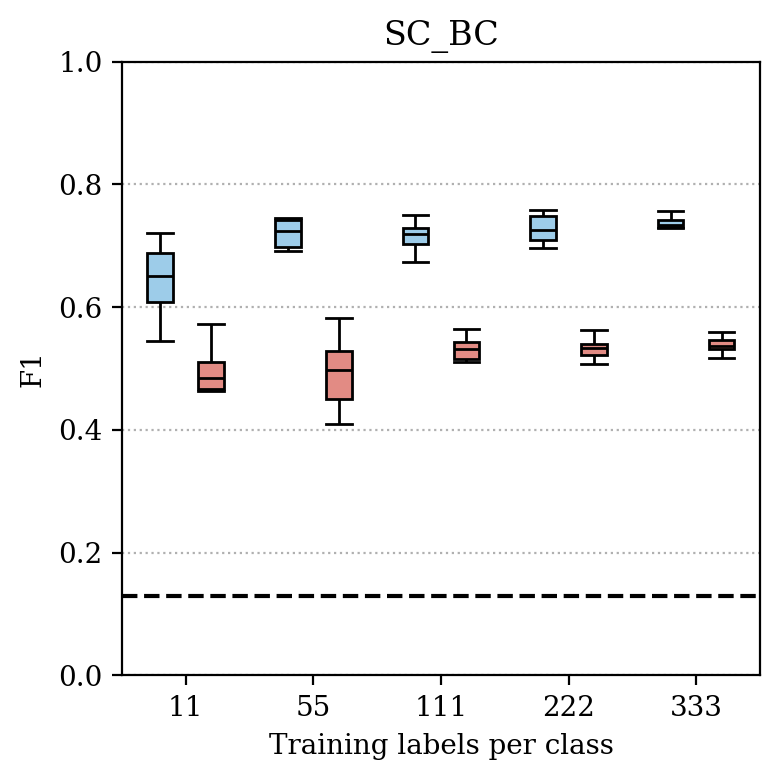

In [6]:
score = 'f1'
cases = ['SC_BC']

palette = {
    'omiclip':'#91cff5',
    'openaiclip':'#f27d74',
    'dummy':'k'
}

for TEST_CASE in cases:
    df = pd.DataFrame()
    for MODEL in ['omiclip', 'openaiclip']:
        NAME = f'{MODEL}-{TEST_CASE}-{MODALITY}'
        cos_file = os.path.join(datadir, f'{NAME}-{score}_scores.csv')

        df_model = pd.read_csv(cos_file)
        df_model['Model'] = MODEL
        df_model = pd.melt(df_model, id_vars=['Model'], var_name='Ratio', value_name=score)
        df = pd.concat([df, df_model])

    # add random model
    for MODEL in ['dummy']:
        NAME = f'{MODEL}-{TEST_CASE}-{MODALITY}'
        cos_file = os.path.join(randomdir, f'{NAME}-{score}_scores.csv')

        df_model = pd.read_csv(cos_file)
        df_model['Model'] = MODEL
        df_model = pd.melt(df_model, id_vars=['Model'], var_name='Ratio', value_name=score)
        dummy_median = df_model[df_model['Model']=='dummy'][score].median()

    df = getTopEntries(df)
    fig = plt.figure(figsize=(4,4), frameon=False, dpi=200)
    ax = sns.boxplot(df, widths=0.2, fliersize=0, hue='Model', x='Ratio', y=score, palette=palette)
    ax.set_xlabel('Training labels per class')
    ax.set_ylabel(score.upper())
    ax.set_title(TEST_CASE)

    ax.axhline(dummy_median, color='black', linestyle='--', label='Random')
    ax.grid(visible=None, which='major', axis='y', linestyle=':')

    ax.get_legend().remove()
    plt.ylim(0, 1)
    plt.tight_layout()
    fig.savefig(os.path.join(datadir, f"{score}_boxplot_{TEST_CASE}.png"), dpi=600)


## Functions

### UMAP

In [5]:
# plot umap as scatter plot, color by annotations (a list of strings)
def scatter_plot(embedding, annotations, palette=None, save_path=None, **kwargs):

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.figsize'] = (6, 4)

    if palette is None:
        default_palette = 'tab20'
        palette = dict(zip(set(annotations), plt.cm.get_cmap(default_palette).colors))

    plt.figure()
    for i, label in enumerate(set(annotations)):
        indices = np.where(np.array(annotations) == label)[0]
        color = palette[label]
        plt.scatter(embedding[indices, 0], embedding[indices, 1], label=label, c=color, **kwargs)

    # place the legend outside the plot
    s = kwargs['s']
    plt.legend(bbox_to_anchor=(1.05, 1), markerscale=5/np.sqrt(s), loc="upper left")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

### Confusion matrix

In [13]:
def plot_confusion_matrix(
    y_true, y_pred, normalize=False, norm_axis=1, title=None, cmap="Blues", save_path=None
):
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    from pathlib import Path

    cm = confusion_matrix(y_true, y_pred)

    if not title:
        title = "Normalized confusion matrix" if normalize else "Confusion matrix"

    #cm = confusion_matrix(y_true, y_pred)
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_true, y_pred)

    if normalize:
        if norm_axis == 1:
            cm = cm.astype("float") / cm.sum(axis=norm_axis)[:, np.newaxis]
        if norm_axis == 0:
            cm = cm.astype("float") / cm.sum(axis=norm_axis)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation=None, cmap=cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True",
        xlabel="Predicted",
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()


In [51]:
def plot_confusion_matrix_order(
    y_true, y_pred, normalize=None, norm_axis=1, annotate_original=True, label_or_bar='bar', title=None, ordered_labels=[], cmap="Blues", save_path=None
):
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    from pathlib import Path

    cm = confusion_matrix(y_true, y_pred)
    cm_orig = cm.copy()
    
    if not title:
        title = "Normalized confusion matrix" if normalize else "Confusion matrix"

    unique_classes = unique_labels(y_true, y_pred)
    classes = sorted(unique_classes, key=lambda x: ordered_labels.index(x))
    
    # Get the indices of the sorted classes
    sorted_indices = [np.where(unique_classes == i)[0][0] for i in classes]

    # Sort the confusion matrix
    cm = cm[sorted_indices, :]
    cm = cm[:, sorted_indices]
    
    cm_orig = cm_orig[sorted_indices, :][:, sorted_indices]
    
    if normalize:
        if norm_axis == 1:
            cm = cm.astype("float") / cm.sum(axis=norm_axis)[:, np.newaxis]
        if norm_axis == 0:
            cm = cm.astype("float") / cm.sum(axis=norm_axis)
        
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if label_or_bar == 'bar':
        ax.set(
            xticks=[],
            yticks=[],
            title=title,
            ylabel="True",
            xlabel="Predicted",
        )

        for i, class_name in enumerate(classes):
            ax.bar(i, height=0.25, bottom=-0.75, color=palette[class_name], edgecolor=None, linewidth=0, align='center', width=1)
            ax.barh(i, width=0.25, left=-0.75, color=palette[class_name], edgecolor=None, linewidth=0, align='center', height=1)
        ax.axis('off')

    elif label_or_bar == 'label':
        ax.set(
            xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes,
            yticklabels=classes,
            title=title,
            ylabel="True",
            xlabel="Predicted",
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    if annotate_original:
        fmt = "d"
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j,
                    i,
                    format(cm_orig[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8,
                )

    else:
        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j,
                    i,
                    format(cm[i, j], fmt if cm[i, j] >= 0.005 else ".0f"),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )


    fig.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()


## Test case BC

/tmp/ipykernel_1036222/663309467.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[indices, 0], embedding[indices, 1], label=label, c=color, **kwargs)


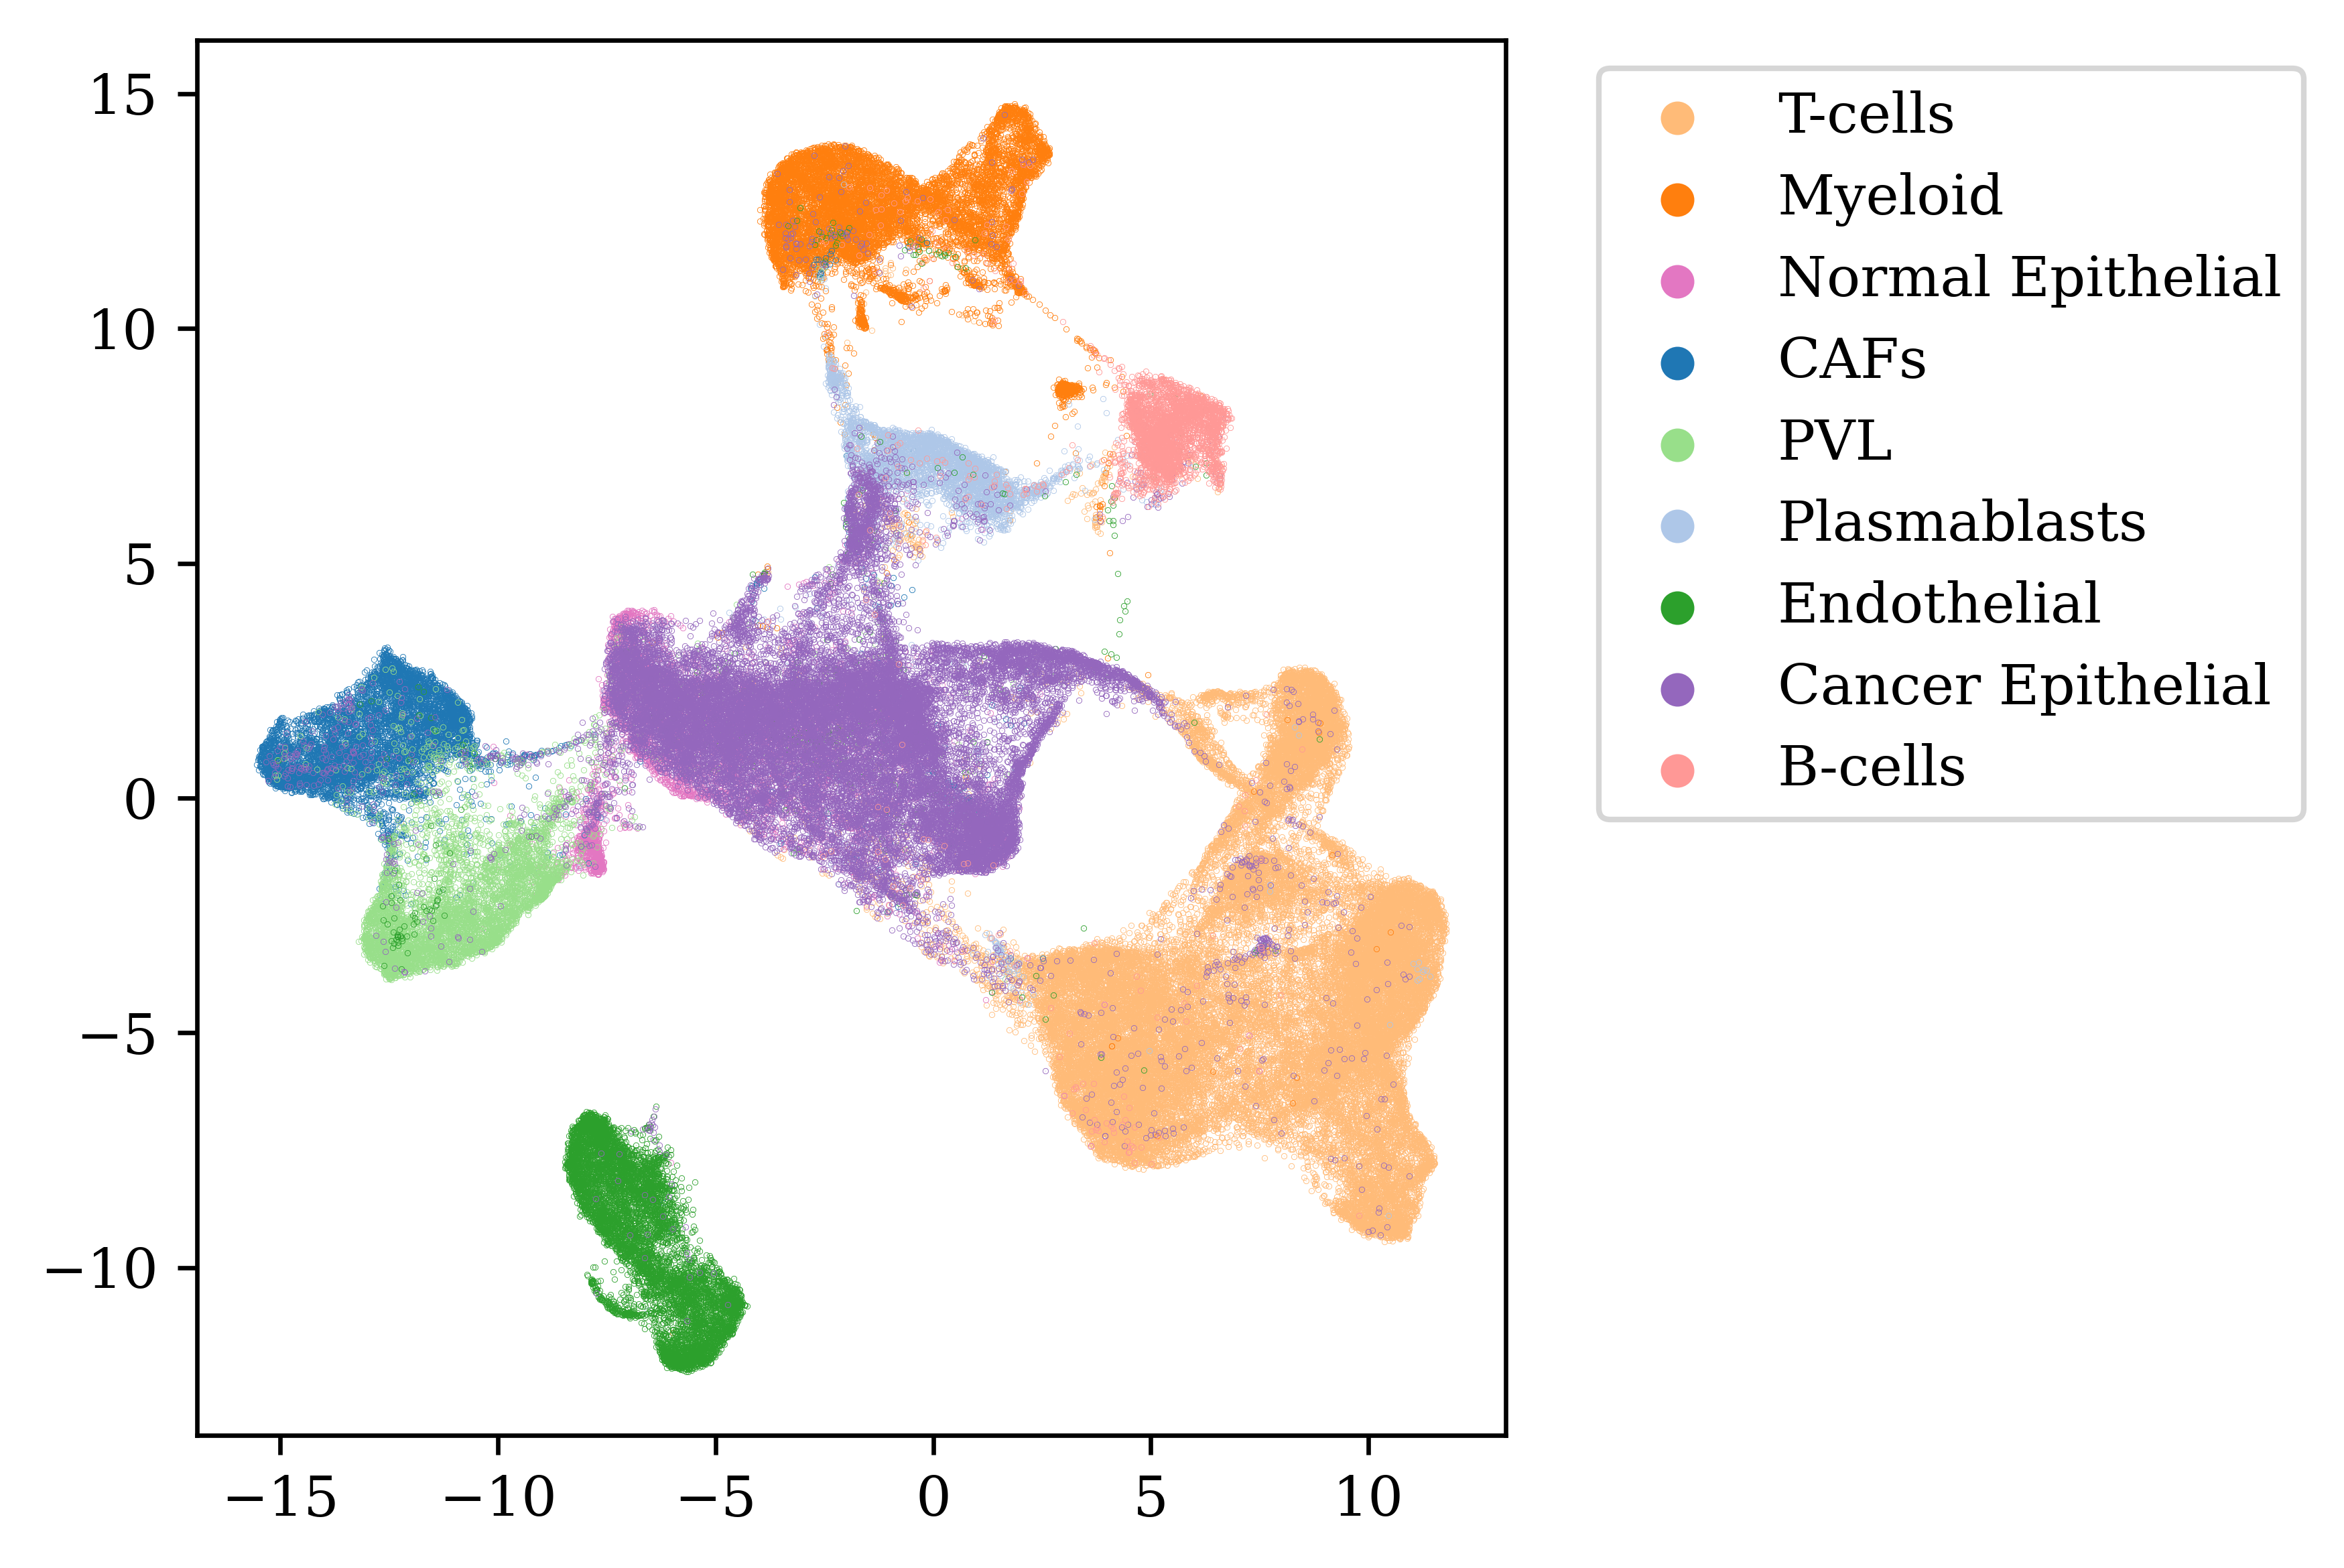

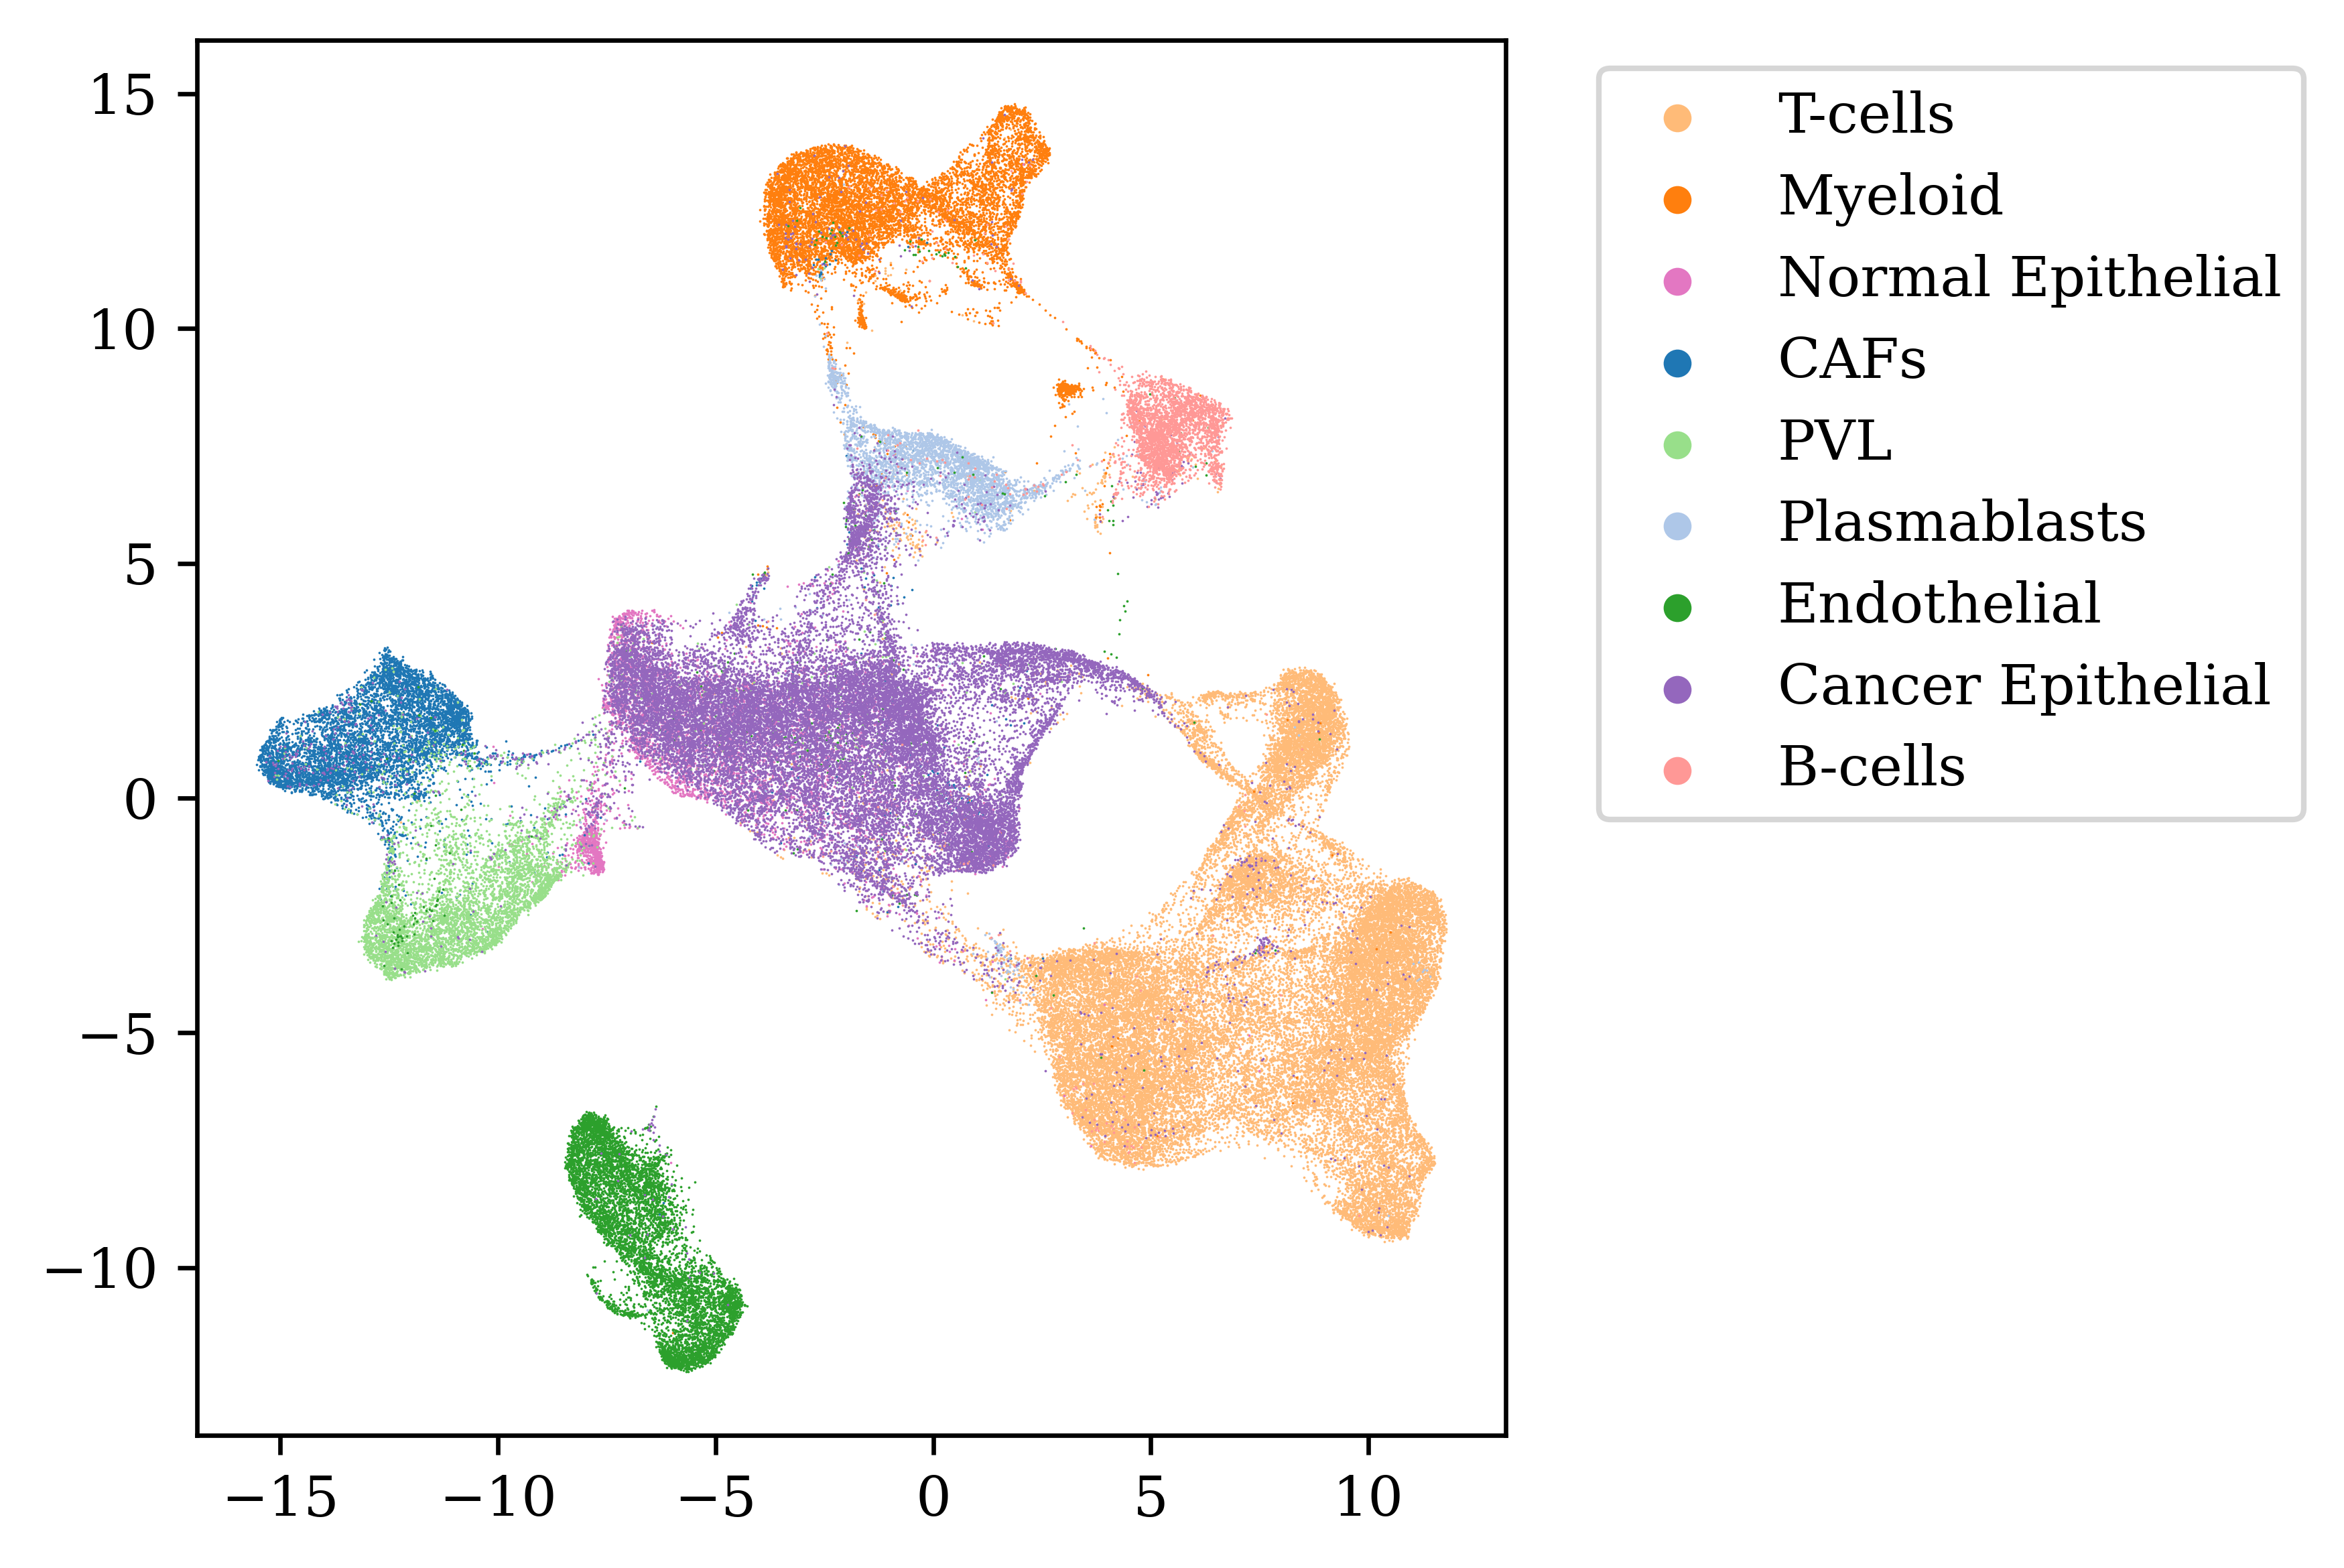

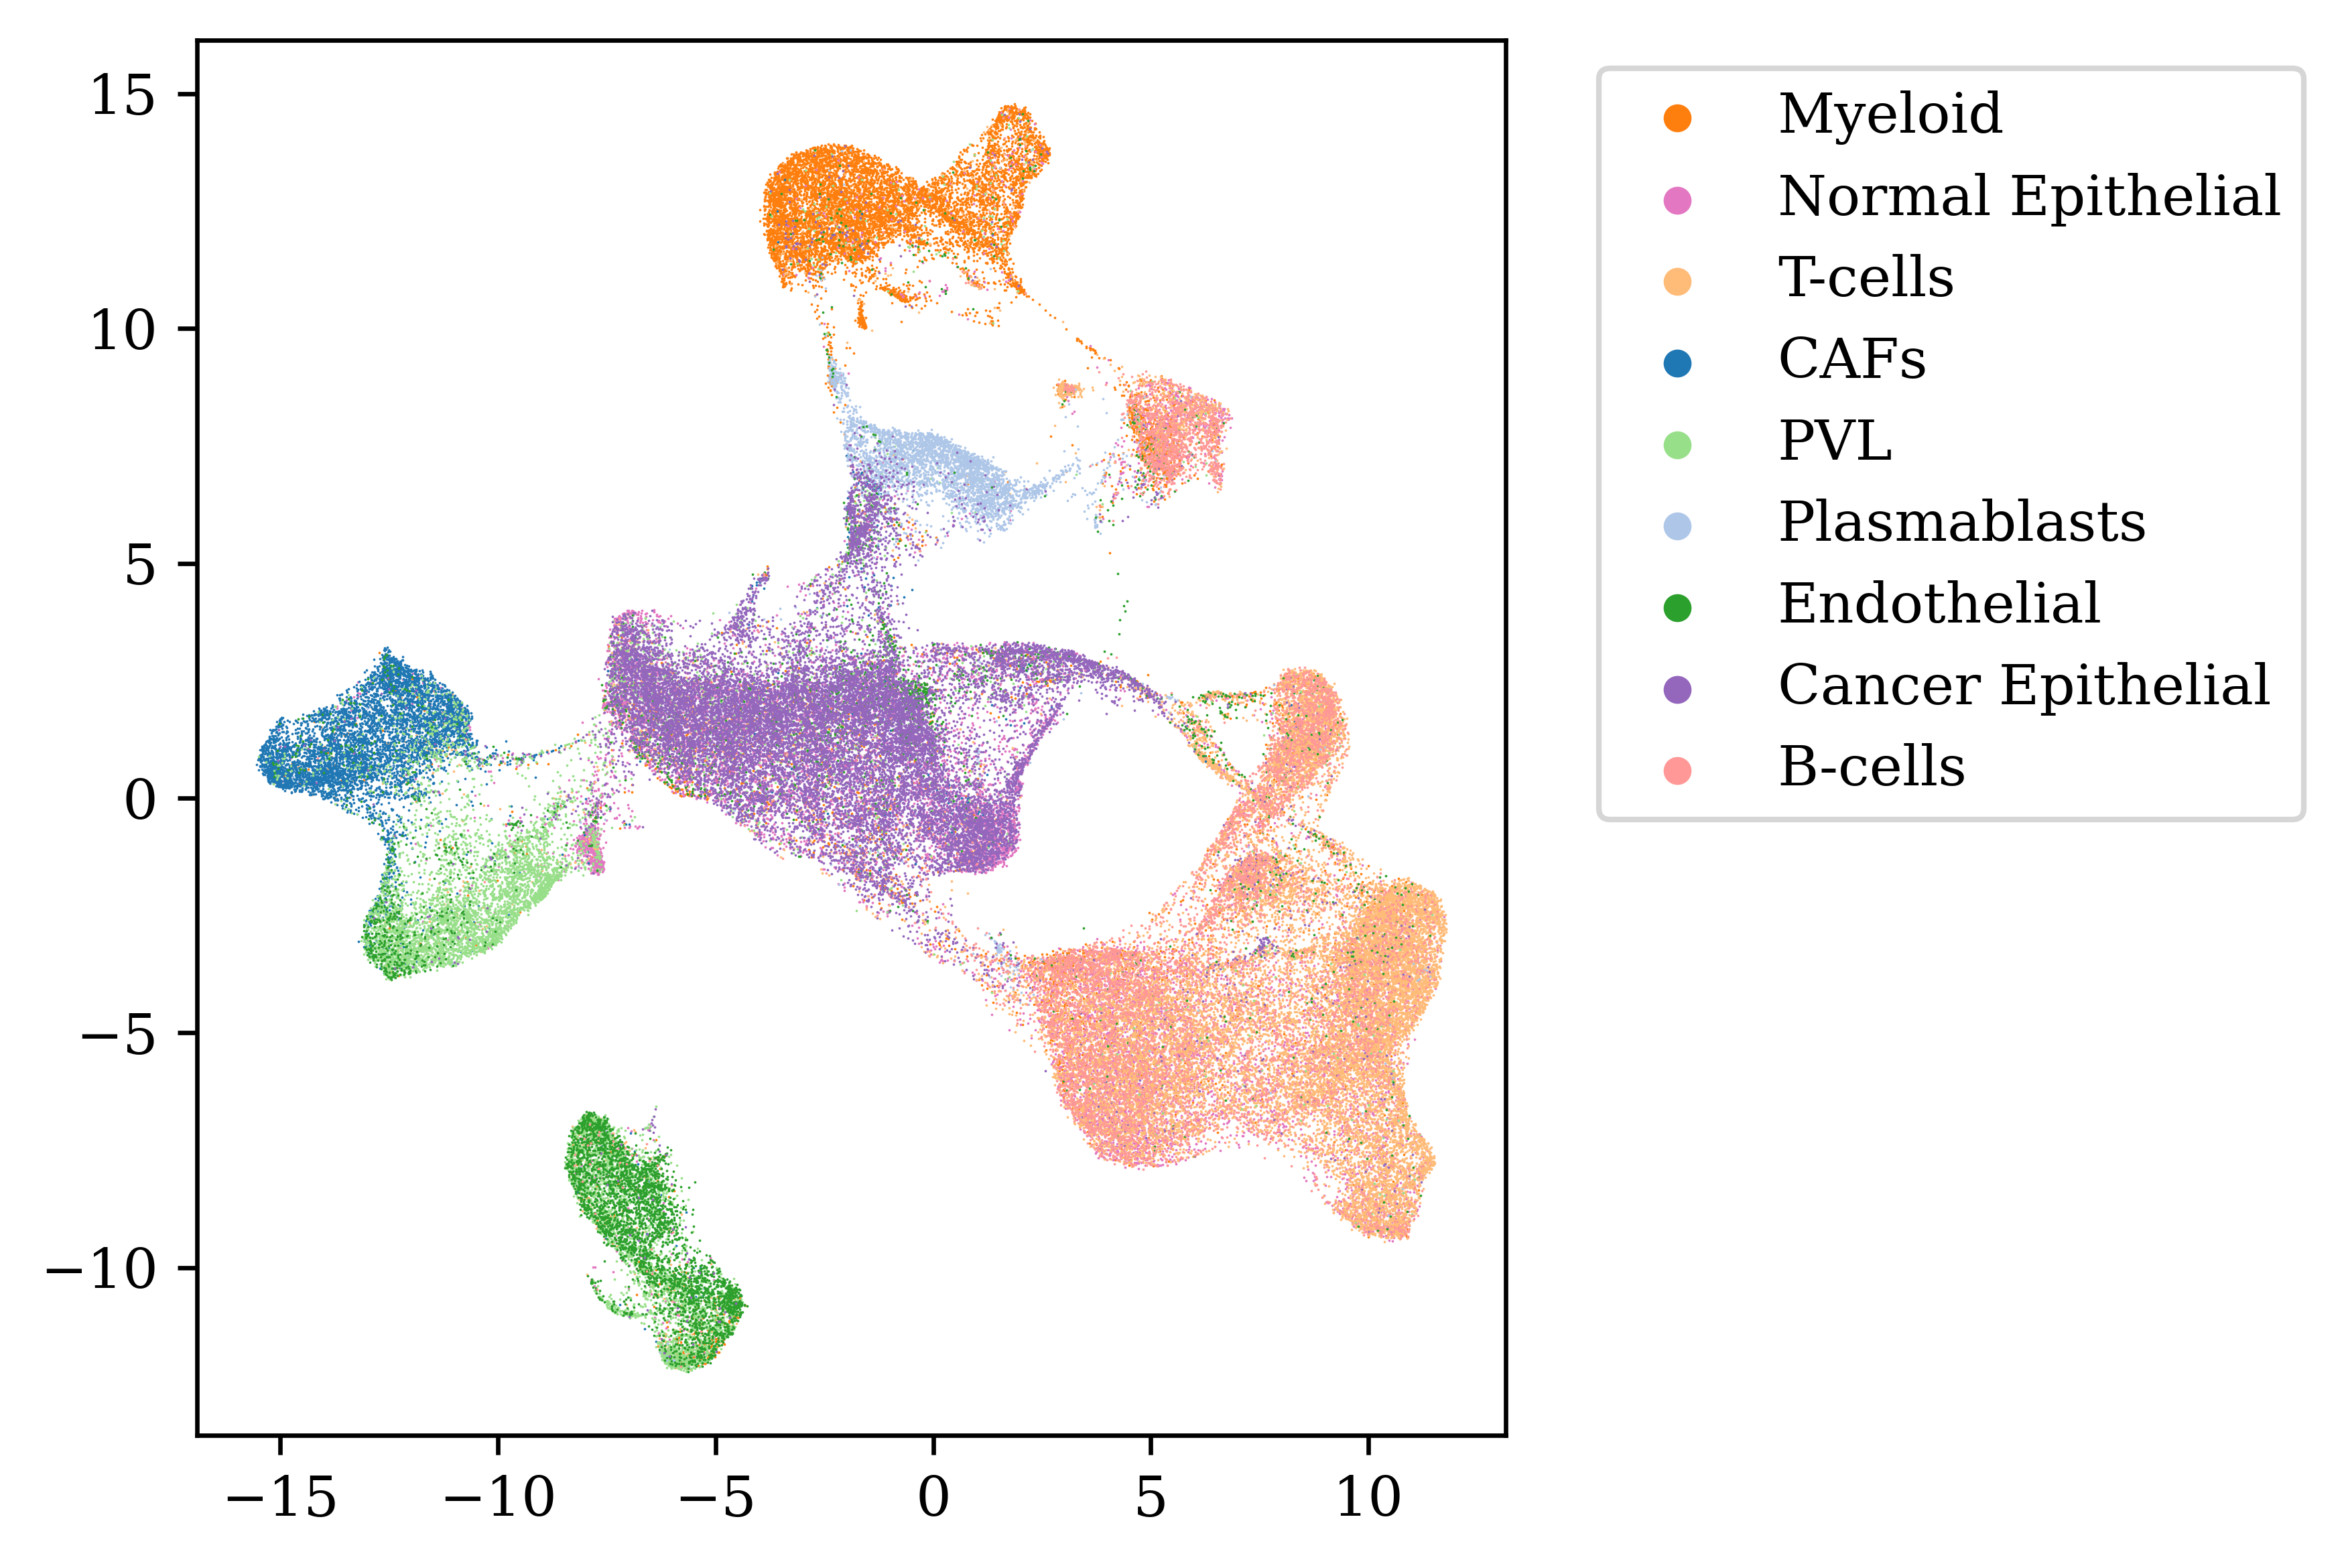

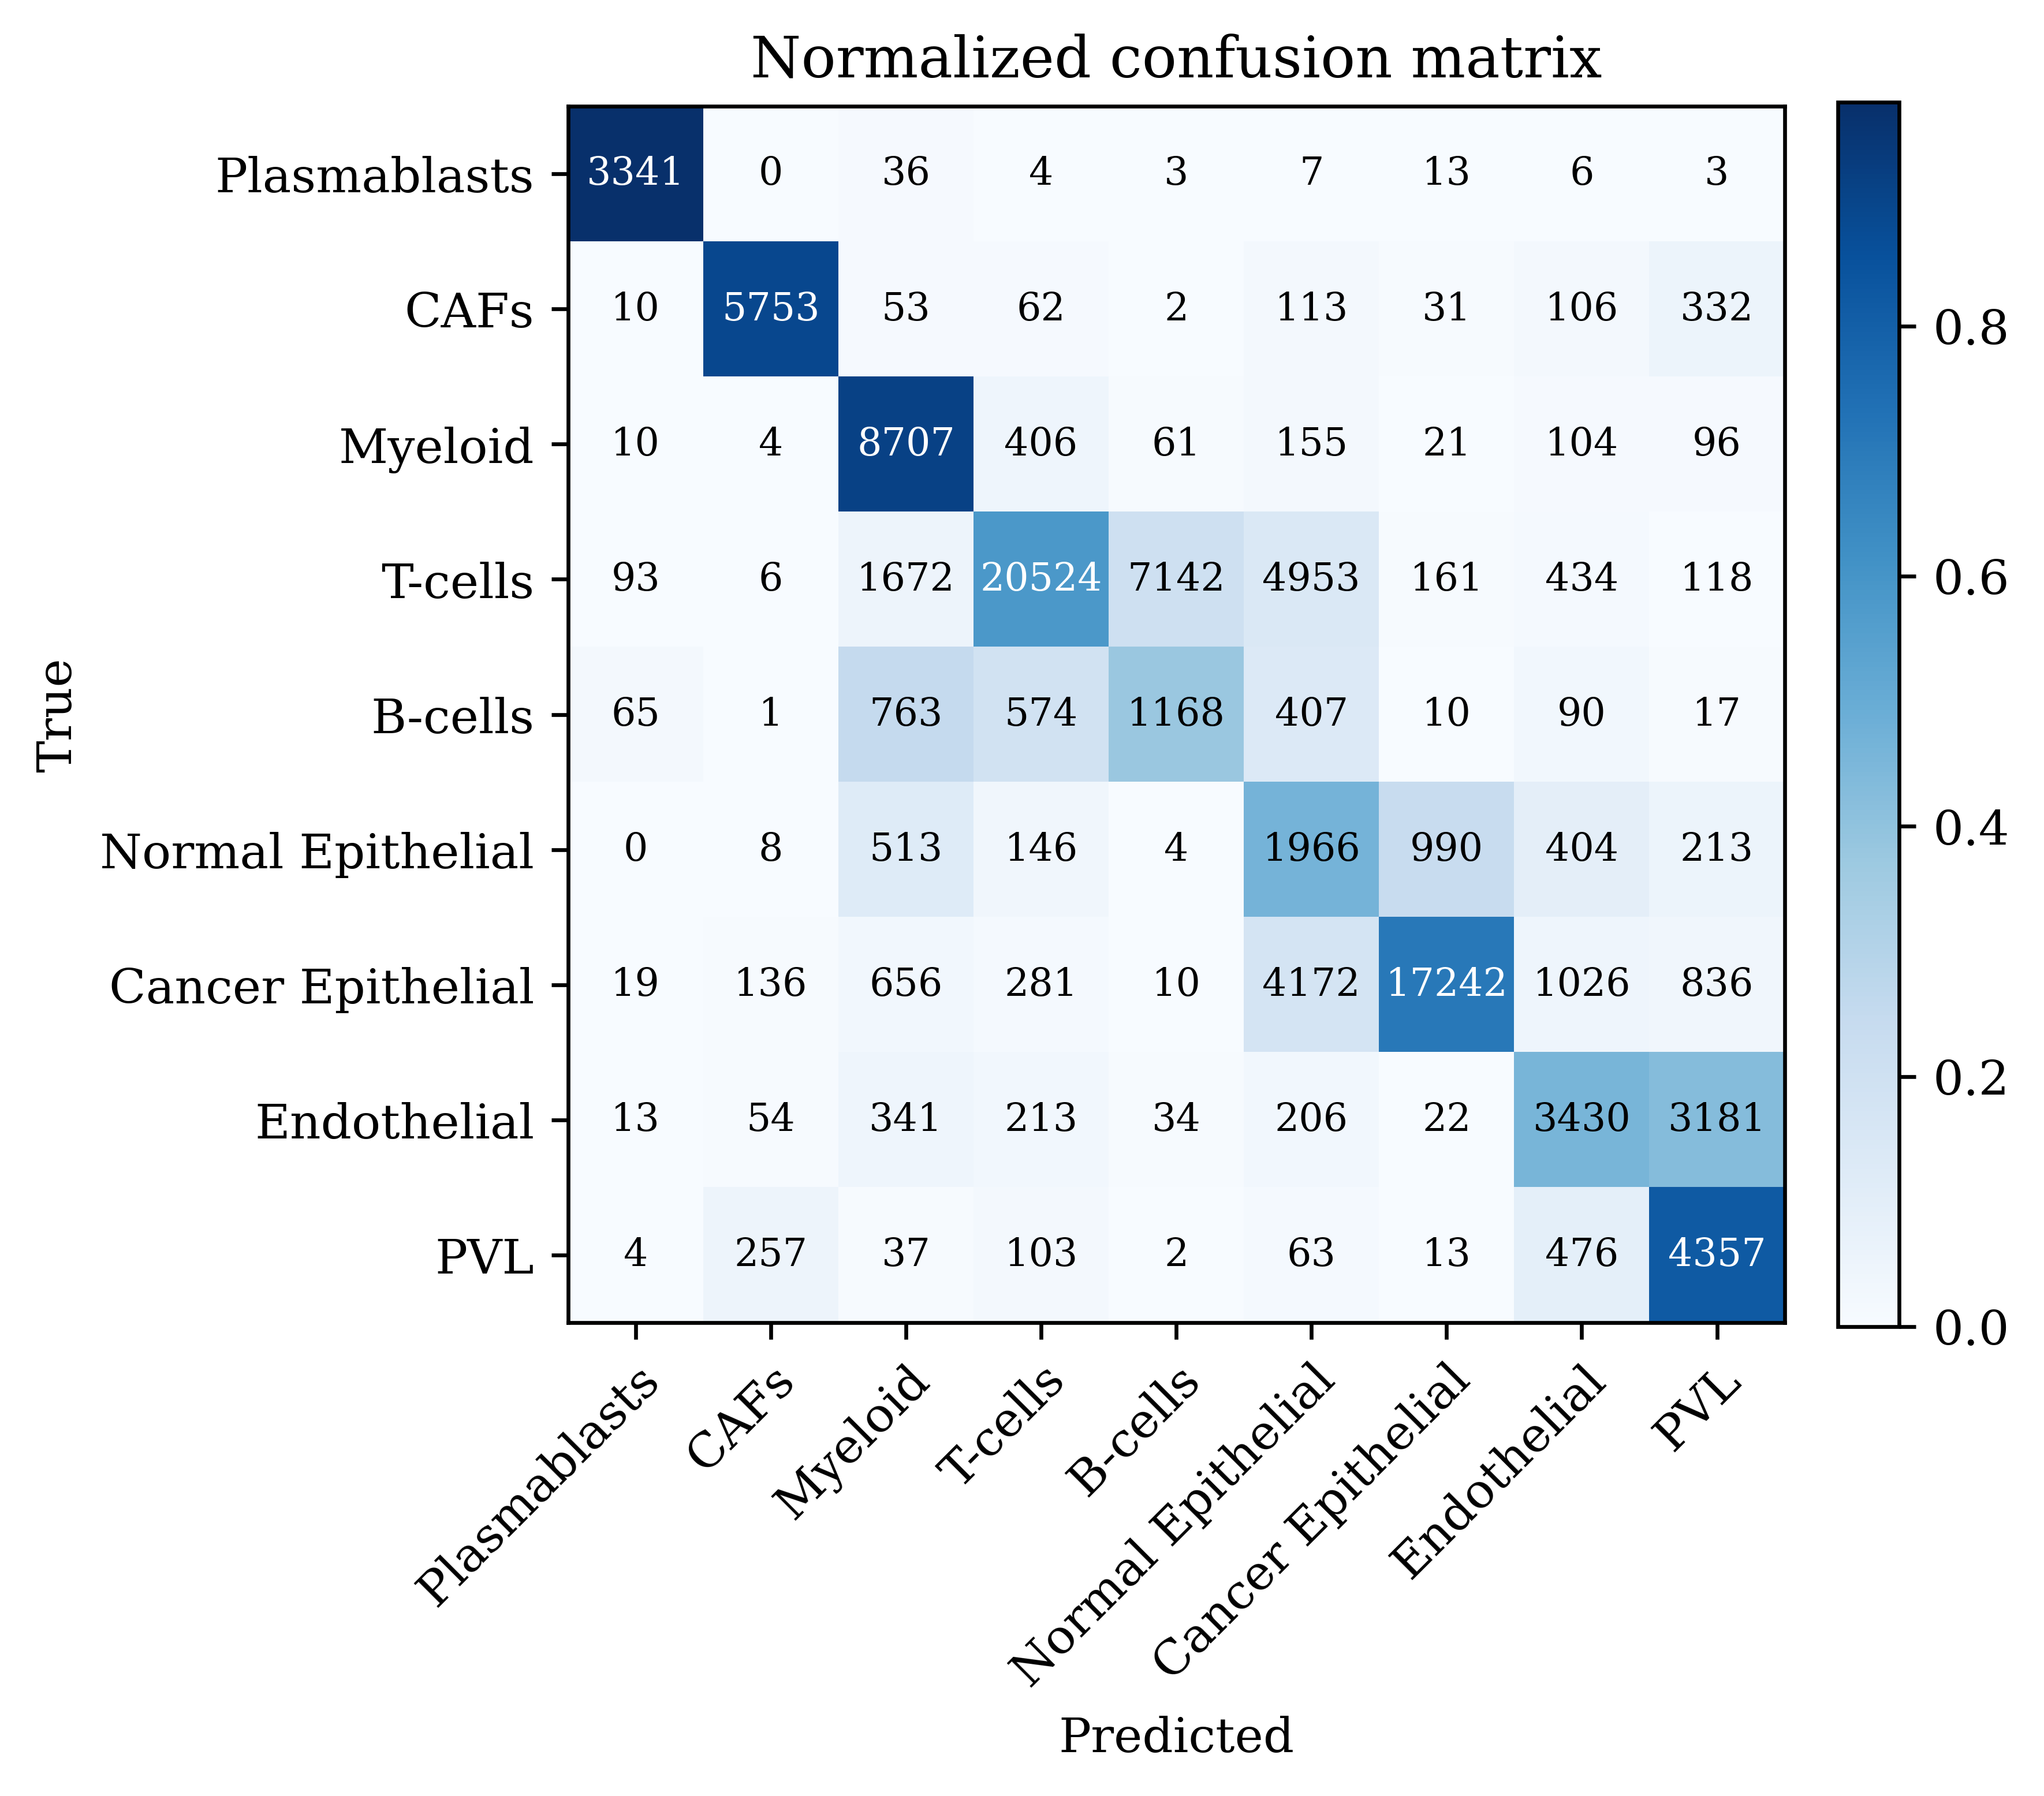

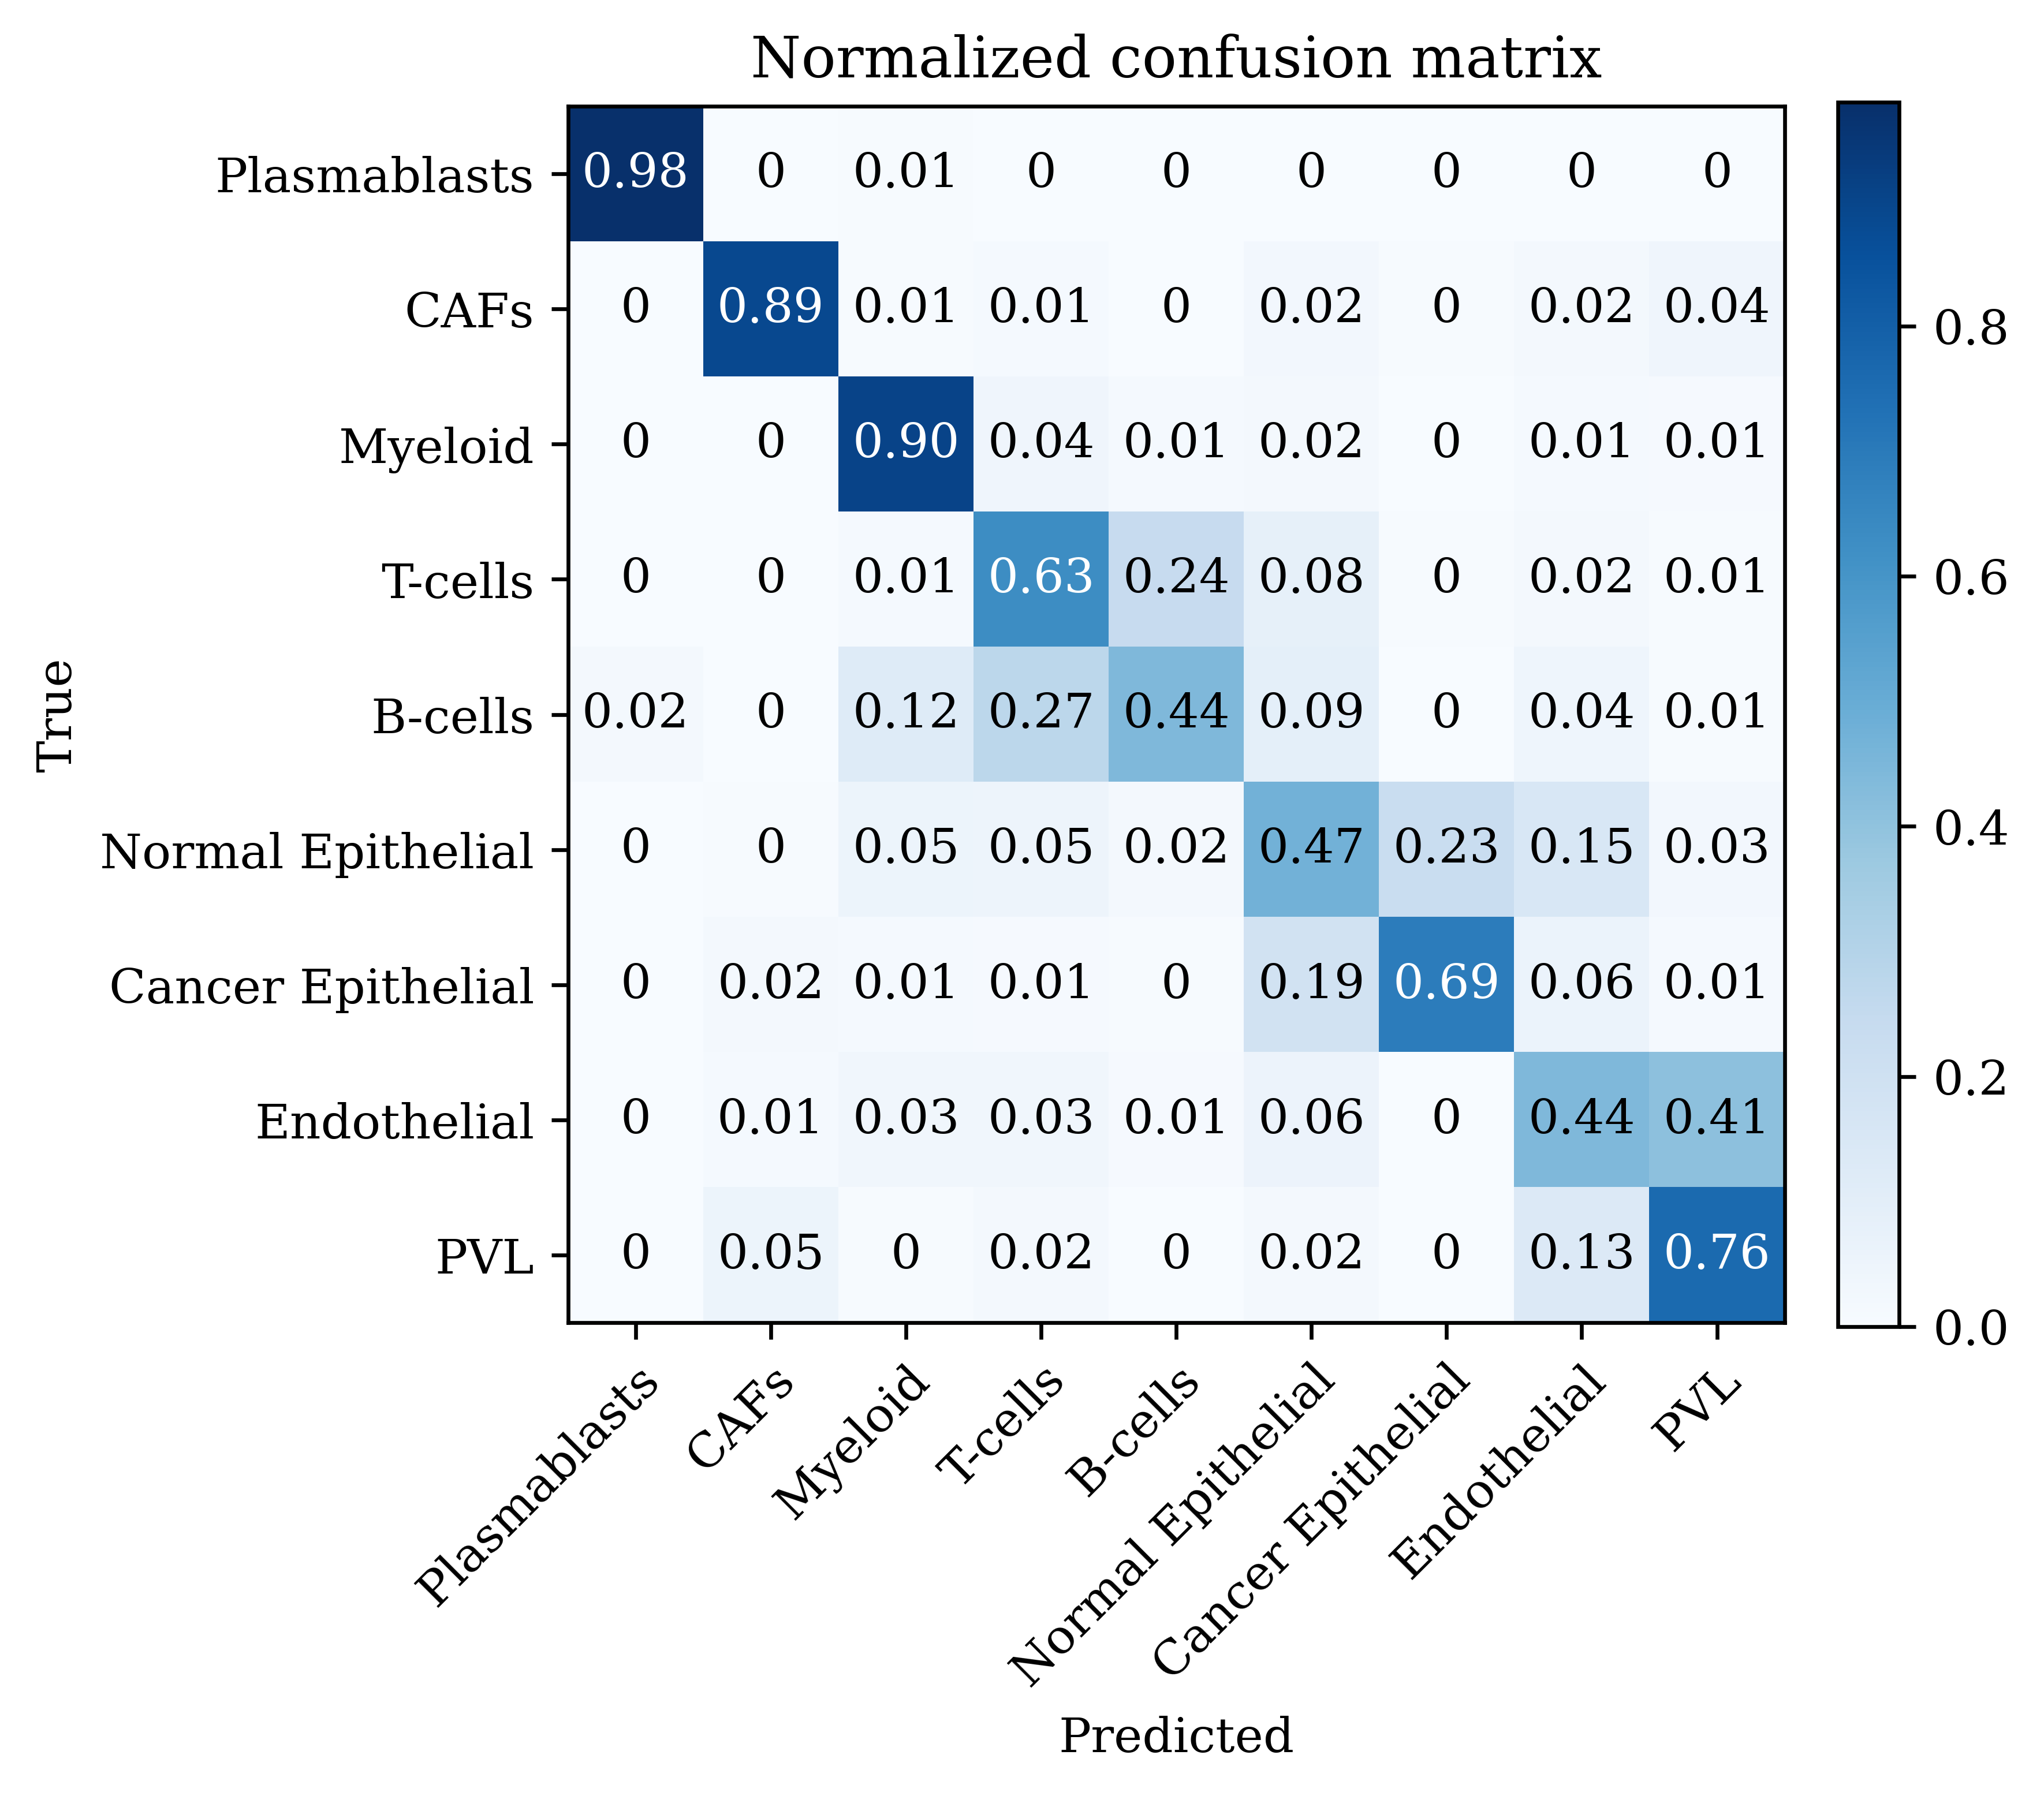

In [53]:
TEST_CASE = 'SC_BC'
model = 'omiclip'
modality = 'text'
metadata_dir = os.path.join("results_low_dimension/meta", TEST_CASE)
training_labes_per_class = 111

result_file_path = os.path.join(metadata_dir, f"{model}-{TEST_CASE}-{modality}-training_data_indices_truth_preds_ratio{training_labes_per_class}.csv")
umap_path = os.path.join(TEST_CASE, f"{TEST_CASE}_umap.npy")

x_umap = np.load(umap_path)

result_df = pd.read_csv(result_file_path)

annotations = result_df['Truth']

#annotations_order = pd.read_csv(os.path.join(f"{TEST_CASE}", f"{TEST_CASE}_labels.csv"), sep="\t")['cell_type'].tolist()

ordered_labels=['Plasmablasts', 'CAFs', 'Myeloid', 'T-cells', 'B-cells', 'Normal Epithelial', 'Cancer Epithelial',  'Endothelial', 'PVL']
# palette = dict(zip(ordered_labels, mpl.colormaps['tab20'].colors))

palette = {
    'Plasmablasts': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
    'CAFs': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    'Myeloid': (1.0, 0.4980392156862745, 0.054901960784313725),
    'T-cells': (1.0, 0.7333333333333333, 0.47058823529411764),
    'B-cells': (1.0, 0.596078431372549, 0.5882352941176471),
    'Normal Epithelial':  (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    'Cancer Epithelial': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
    'Endothelial': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    'PVL': (0.596078431372549, 0.8745098039215686, 0.5411764705882353)
}

scatter_plot(
    x_umap,
    annotations,
    palette=palette,
    s=0.01,
    save_path=os.path.join(datadir, f"{TEST_CASE}-umap_ground_truth.png"),
)

run = 1
for_test = result_df[f'Train_run{run}'] == 0

x_umap_test = x_umap[for_test]
annotations_truth = result_df.loc[for_test, 'Truth']
annotations_pred = result_df.loc[for_test, f'Preds_run{run}']

scatter_plot(
    x_umap_test,
    annotations_truth,
    palette=palette,
    s=0.2,
    linewidths=0,
    edgecolors=None,
    save_path=os.path.join(datadir, f"{model}-{TEST_CASE}-umap_truth_{training_labes_per_class}_run{run}.png"),
)

scatter_plot(
    x_umap_test,
    annotations_pred,
    palette=palette,
    s=0.2,
    linewidths=0,
    edgecolors=None,
    save_path=os.path.join(datadir, f"{model}-{TEST_CASE}-umap_predict_{training_labes_per_class}_run{run}.png"),
)

plot_confusion_matrix_order(
    annotations_truth, annotations_pred, normalize=True, norm_axis=1, annotate_original=True, label_or_bar='label',
    ordered_labels=ordered_labels, 
    title=None, cmap="Blues", 
    save_path=os.path.join(datadir, f"{model}-{TEST_CASE}-confusion_predict_{training_labes_per_class}_run{run}.png"),
)

annotations_truth_all = []
annotations_pred_all = []
for run in range(1, 11):
    for_test = result_df[f'Train_run{run}'] == 0
    annotations_truth_all.extend(result_df.loc[for_test, 'Truth'])
    annotations_pred_all.extend(result_df.loc[for_test, f'Preds_run{run}'])

plot_confusion_matrix_order(
    annotations_truth_all, annotations_pred_all, normalize=True, norm_axis=1, annotate_original=False, label_or_bar='label',
    ordered_labels=ordered_labels, 
    title=None, cmap="Blues", 
    save_path=os.path.join(datadir, f"{model}-{TEST_CASE}-confusion_predict_{training_labes_per_class}.png"),
)